**Sentiment Analysis using RNN models**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import string
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Dataset loading**

In [2]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

#zip 파일 현재 폴더로 복사, 중간 부분은 파일명에 따라 변경 필요
!cp '/content/drive/MyDrive/IMDB Dataset.csv.zip' ./

Mounted at /content/drive


In [3]:
#압축 해제
!unzip 'IMDB Dataset.csv.zip'

Archive:  IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
#구현 필요

#데이터프레임 확인
base_csv='IMDB Dataset.csv'
df=pd.read_csv(base_csv)
df.head()




,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Pre-process the dataset**

In [6]:
#구현 필요

#train/test 데이터 분할, test_size=0.2

X,y=df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')


shape of train data is (40000,)
shape of test data is (10000,)


In [8]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train, dtype=object), np.array(encoded_train),np.array(final_list_test, dtype=object), np.array(encoded_test),onehot_dict

In [9]:
#구현 필요

#tokenize 함수 실행
x_train,y_train,x_test,y_test,vocab=tokenize(x_train,y_train,x_test,y_test)
print(f'Length of vocabulary is {len(vocab)}')


Length of vocabulary is 1000


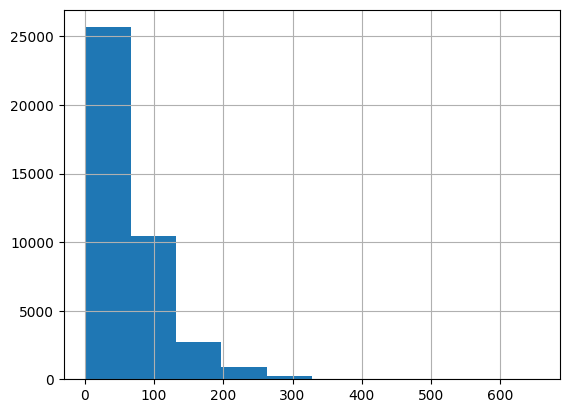

,0
count,40000.000000
mean,69.286050
std,48.087426
min,2.000000
25%,39.000000
50%,54.000000
75%,84.000000
max,653.000000


In [10]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [11]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

#구현 필요

#train과 test에 대해서 padding_ 함수 실행, seq_len = 200

x_train_pad=padding_(x_train,200)
x_test_pad=padding_(x_test,200)


In [12]:
#구현 필요

# create Tensor datasets

train_data=TensorDataset(torch.from_numpy(x_train_pad),torch.from_numpy(y_train))
test_data=TensorDataset(torch.from_numpy(x_test_pad),torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data

train_loader=DataLoader(train_data,shuffle=True,batch_size=batch_size)
test_loader=DataLoader(test_data,shuffle=False,batch_size=batch_size)


In [13]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[  0,   0,   0,  ...,  59,  54, 143],
        [  0,   0,   0,  ...,  35,   1,   1],
        [  0,   0,   0,  ...,   8, 567, 253],
        ...,
        [  0,   0,   0,  ..., 965, 205,  24],
        [  0,   0,   0,  ...,  11,   1,   1],
        [  0,   0,   0,  ...,  58, 239, 459]])
Sample input: 
 tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1])


**GRU model code**

In [14]:
class GRU_model(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, device):
        super(GRU_model, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device

        #구현 필요
        self.embed=nn.Embedding(n_vocab,embed_dim)
        self.gru=nn.GRU(embed_dim,self.hidden_dim,num_layers=self.n_layers,batch_first=True)
        self.out=nn.Linear(self.hidden_dim,n_classes)


    def forward(self, x):
        #구현 필요
        x=self.embed(x)
        h_0=self._init_state(batch_size=x.size(0))
        x,_=self.gru(x,h_0)
        h_t=x[:,-1,:]
        logit=self.out(h_t)
        return logit


    def _init_state(self, batch_size):
        #구현 필요
        new_state=torch.zeros(self.n_layers,batch_size,self.hidden_dim).to(self.device)
        return new_state



In [15]:
n_layers = 1
vocab_size = len(vocab) + 1  # extra 1 for <pad>
hidden_dim = 128
embed_dim = 100
n_classes = 2

#구현 필요

#GRU 모델 객체 생성
model=GRU_model(n_layers,hidden_dim,vocab_size,embed_dim,n_classes,device).to(device)


**Train and evaluation**

In [16]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss = 0
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logit = model(x)
        loss = criterion(logit, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    return train_loss / len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    corrects, total_loss = 0, 0
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)

        logit = model(x)
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(data_loader.dataset)

    avg_accuracy = 100.0 * corrects / size
    return avg_accuracy

In [17]:
num_epochs = 10
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for e in range(1, num_epochs+1):
    train_loss = train(model, criterion, optimizer, train_loader)
    test_accuracy = evaluate(model, test_loader)
    print("[Epoch: %d] train loss : %5.2f | test accuracy : %5.2f" % (e, train_loss, test_accuracy))

[Epoch: 1] train loss :  0.45 | test accuracy : 84.62
[Epoch: 2] train loss :  0.33 | test accuracy : 85.66
[Epoch: 3] train loss :  0.29 | test accuracy : 85.16
[Epoch: 4] train loss :  0.26 | test accuracy : 85.72
[Epoch: 5] train loss :  0.21 | test accuracy : 84.93
[Epoch: 6] train loss :  0.16 | test accuracy : 85.44
[Epoch: 7] train loss :  0.11 | test accuracy : 84.89
[Epoch: 8] train loss :  0.07 | test accuracy : 84.11
[Epoch: 9] train loss :  0.05 | test accuracy : 84.44
[Epoch: 10] train loss :  0.04 | test accuracy : 84.13


**LSTM model code**

In [21]:
class LSTM_model(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, device):
        super(LSTM_model, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device

        #구현 필요
        self.embed=nn.Embedding(n_vocab,embed_dim)
        self.lstm=nn.LSTM(embed_dim,self.hidden_dim,num_layers=self.n_layers,batch_first=True)
        self.out=nn.Linear(self.hidden_dim,n_classes)


    def forward(self, x):
        #구현 필요
        x=self.embed(x)
        h_0=self._init_state(batch_size=x.size(0))
        x,_=self.lstm(x,h_0)
        h_t=x[:,-1,:]
        logit=self.out(h_t)
        return logit


    def _init_state(self, batch_size):
        #구현 필요
        new_cell_state=torch.zeros(self.n_layers,batch_size,self.hidden_dim).to(self.device)
        new_hidden_state=torch.zeros(self.n_layers,batch_size,self.hidden_dim).to(self.device)
        return (new_hidden_state,new_cell_state)



**LSTM training and evaluation**

In [22]:
#구현 필요

#LSTM 모델 객체 생성
model=LSTM_model(n_layers,hidden_dim,vocab_size,embed_dim,n_classes,device).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for e in range(1, num_epochs+1):
    train_loss = train(model, criterion, optimizer, train_loader)
    test_accuracy = evaluate(model, test_loader)
    print("[Epoch: %d] train loss : %5.2f | test accuracy : %5.2f" % (e, train_loss, test_accuracy))

[Epoch: 1] train loss :  0.46 | test accuracy : 82.77
[Epoch: 2] train loss :  0.36 | test accuracy : 85.36
[Epoch: 3] train loss :  0.32 | test accuracy : 85.15
[Epoch: 4] train loss :  0.30 | test accuracy : 85.41
[Epoch: 5] train loss :  0.25 | test accuracy : 85.36
[Epoch: 6] train loss :  0.22 | test accuracy : 85.40
[Epoch: 7] train loss :  0.18 | test accuracy : 84.49
[Epoch: 8] train loss :  0.13 | test accuracy : 83.23
[Epoch: 9] train loss :  0.09 | test accuracy : 84.11
[Epoch: 10] train loss :  0.06 | test accuracy : 84.08


**Vanilla RNN model code**

In [23]:
class RNN_model(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, device):
        super(RNN_model, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device

        #구현 필요
        self.embed=nn.Embedding(n_vocab,embed_dim)
        self.rnn=nn.RNN(embed_dim,self.hidden_dim,num_layers=self.n_layers,batch_first=True)
        self.out=nn.Linear(self.hidden_dim,n_classes)


    def forward(self, x):
        #구현 필요
        x=self.embed(x)
        h_0=self._init_state(batch_size=x.size(0))
        x,_=self.rnn(x,h_0)
        h_t=x[:,-1,:]
        logit=self.out(h_t)
        return logit


    def _init_state(self, batch_size):
        #구현 필요
        new_state=torch.zeros(self.n_layers,batch_size,self.hidden_dim).to(self.device)



In [24]:
#구현 필요

#vanilla RNN 모델 객체 생성
model=RNN_model(n_layers,hidden_dim,vocab_size,embed_dim,n_classes,device).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for e in range(1, num_epochs+1):
    train_loss = train(model, criterion, optimizer, train_loader)
    test_accuracy = evaluate(model, test_loader)
    print("[Epoch: %d] train loss : %5.2f | test accuracy : %5.2f" % (e, train_loss, test_accuracy))

[Epoch: 1] train loss :  0.60 | test accuracy : 73.78
[Epoch: 2] train loss :  0.58 | test accuracy : 72.01
[Epoch: 3] train loss :  0.54 | test accuracy : 71.11
[Epoch: 4] train loss :  0.53 | test accuracy : 79.36
[Epoch: 5] train loss :  0.48 | test accuracy : 79.82
[Epoch: 6] train loss :  0.45 | test accuracy : 77.67
[Epoch: 7] train loss :  0.49 | test accuracy : 75.69
[Epoch: 8] train loss :  0.58 | test accuracy : 77.45
[Epoch: 9] train loss :  0.61 | test accuracy : 73.88
[Epoch: 10] train loss :  0.57 | test accuracy : 78.78
